In [2]:
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from IPython.display import Image, display
#Heavy lifting is done in the imported module below
from sparse_fluxqubit import *

In [11]:
#Any of these values can be assigned as a sweep.
#Just run a for loop over the corresponding matrices.
#See Flux Qubit Calculations.ipynb for examples with the
#bias point and relative junction areas.

#=========
#Constants
#=========

Phi0 = 2.067833e-15 #Flux quanta [Wb]
h = 6.626e-34       #Planck's constant

#===========================
# Junction Design Parameters
#===========================

#Set the scale of Ej and tune the relative weights of the 
#physically designed junctions around that scale

Jc = 50e1     #Critical current density [A/cm^2]
JA = 1e-9    #Junction Area [cm^2]

Ic = Jc*JA    #Critical current [A]
Ej = Phi0*Ic/(2.0*np.pi)/h/1e9  # Josephson energy [GHz]

Ec = 5    #Charging energy [GHz]


#relative junction areas to JA of the physical junctions
r1 = 1.42
r2 = 0.7
r3 = 0.7
r4 = 0.7

#Bias point of the flux qubit
f = np.linspace(0,1,101)

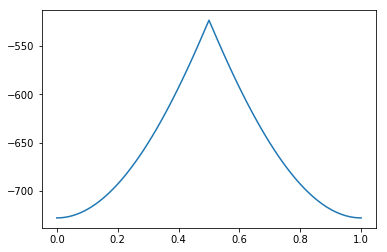

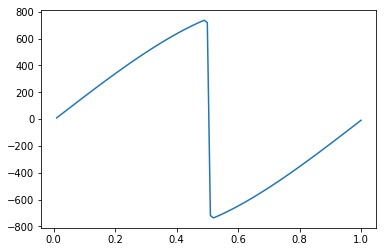

In [13]:
#====================
#Generate Hamiltonian
#====================

# Number of eigenvals(vecs) to return. MUST be smaller than nmax. Sparse diagonalization
# algorithm must return less than the size of the matrix. (See scipy documentation)
nelevels = 3 

nmax = 5 #total levels to hamiltonian in calculation (change to run faster or slower)
# bias charges between each island
ng12 = 0
ng23 = 0
ng34 = 0

# Create the generator of the Hamiltonian
ham_generator = four_junction_computation_sparse(nmax)
# ham_generator is a callable object. It essentially forms the skeleton of the Hamiltonian
# and creates the elements that make up the sparse matrix, but does not populate them with
# the proper values. This objet is then called to create a Hamiltonian with those specific
# values which can then be manipulated.

#Create transition matrix generator
t_matrix = transition_matrix(nmax)


t01 = []
t02 = []
t12 = []

gnd_energy = []
E01 = []
E12 = []
Anharm = []

for val in f:
    # Hamiltonian with associated values at bias point f
    H  = ham_generator(Ej,Ec,r1,r2,r3,r4,val,ng12,ng23,ng34)
    # transition matrix at bias point f
    transitions = t_matrix(val)

    #diagonalize the Hamiltonian and get the eigenvals(vecs)
    eigval, eigvec = sp.sparse.linalg.eigsh(H,
                                        k=nelevels,
                                        which='SA',
                                        return_eigenvectors=True)

    #Need to do this to get around some silly zip functionality with numpy arrays
    temp = []
    for i in range(nelevels):
        temp.append(eigvec[:,i])
    zipped = zip(eigval,temp)
    #Sort in terms of ascending eigenvalues and unzip
    eigs, evecs = zip(*sorted(zipped, key=lambda x: x[0]))
    #Convert evecs to sparse for fast matrix math
    evecs = np.transpose(np.array(evecs))
    evecs = sp.sparse.csc_matrix(evecs)

    gnd_energy.append(eigs[0])
    E01.append(eigs[1]-eigs[0])  #gap
    E12.append(eigs[2]-eigs[1])
    Anharm.append(E12[-1] - E01[-1])

    #TODO: Calculate slope for current from deig_gnd/df

    t01_temp = (evecs[:,1].H).dot(transitions.dot(evecs[:,0]))
    t12_temp = (evecs[:,2].H).dot(transitions.dot(evecs[:,1]))
    t02_temp = (evecs[:,2].H).dot(transitions.dot(evecs[:,0]))

    t01.append(t01_temp.data[0])
    t12.append(t12_temp.data[0])
    t02.append(t02_temp.data[0])


gnd_energy = np.array(gnd_energy)
deriv = np.diff(gnd_energy)/np.diff(f)

plt.plot(f,gnd_energy)
plt.show()
plt.plot(f[1:],deriv)
plt.show()